In [265]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import math
from scipy.stats import beta


# Revision datos

In [4]:
df = pd.read_excel('../data/dieta_oscar_MCD.xlsx',
                    sheet_name = 0,
                    engine='openpyxl')

df.columns

Index(['id', 'edad', 'sexo', 'estado', 'peso total', 'Oxalis', 'Quercus',
       'Cyp.bulb', 'Phaseolus', 'Tephoria',
       ...
       'covey', 'dist camino', 'ppanual17', 'tmedia17', 'altitud', 'lat',
       'lon', 'hcrop', 'hland', 'gap'],
      dtype='object', length=146)

In [5]:
#checamos si hay duplasaos
df.duplicated().sum() 

0

In [6]:
#correccion columna sex
df['sexo'] = df['sexo'].apply(lambda x: 'Male' if x == 'male' else 'Female' if x == 'female' else 'Male' if x == 'Male ' else x)


In [144]:
#covariables y variables a estudiar
food_columns = list(df.loc[:,'Oxalis':'Juniperus prob. deppeana'].columns) #vaeriables a estudiar
cob_columns = list(df.loc[:, 'time':'gap'].columns) #varias causales
cob_columns

['time',
 'covey',
 'dist camino',
 'ppanual17',
 'tmedia17',
 'altitud',
 'lat',
 'lon',
 'hcrop',
 'hland',
 'gap']

In [8]:
#serie de peso por alimentos
#vemos que tan seguido aparecen y que tanto peso aportan al buche, pues son importantes para seguir
food_weight_series = df[food_columns].sum() #serie indice comida y valor peso total
food_occurancy_series = (df[food_columns] > 0.01).sum() #serie indice comida y valor peso total

food_info = pd.DataFrame({
    'peso_total':food_weight_series,
    'conteo_total':food_occurancy_series
})

food_stats = food_info.quantile([0.5, 
                                 0.6, 
                                 0.7, 
                                 0.75,
                                 0.78,
                                 0.8, 
                                 0.85, 
                                 0.88,
                                 0.9, 
                                 0.95])
food_stats.index.name = 'percentil'
food_stats

,peso_total,conteo_total
percentil,,
0.50,0.071900,1.00
0.60,0.194020,2.00
0.70,0.539410,3.00
0.75,0.763525,5.50
0.78,1.145070,6.62
0.80,1.566640,9.20
0.85,2.698720,16.30
0.88,3.703980,20.52
0.90,6.360981,27.20


In [9]:
food_weight_series

Oxalis                       31.0007
Quercus                     124.5210
Cyp.bulb                     61.7351
Phaseolus                   101.8077
Tephoria                      4.6114
                              ...   
Phaseolus.1                   0.0929
SPA64                         0.5353
SPA65                         0.0070
Arachnida                     0.1540
Juniperus prob. deppeana      0.0041
Length: 130, dtype: float64

In [10]:
food_occurancy_series

Oxalis                       32
Quercus                      91
Cyp.bulb                     68
Phaseolus                   114
Tephoria                     58
                           ... 
Phaseolus.1                   2
SPA64                         2
SPA65                         0
Arachnida                     1
Juniperus prob. deppeana      0
Length: 130, dtype: int64

In [ ]:
alimento --> peso total (suma de cada individuo)
alimento --> númeroo de individuos que lo comieron

In [11]:
df.shape

(319, 146)

El 80% de los alimentos solo aparece en 9 de 319 individuas mientras que el 90% de los datos aparece en al menos 27 individuas. 
En cuanto al peso, solo el 90% de los datos tiene un peso mayor al 6.3 gramos contando todos los individuos.
Se tomara solo los alimentos cuyo peso total supera 18 gramos y que aparezcan minimo en 50 individuos, aproximadamente los percentelies 90.

In [78]:
#filtro pora ver alimentos que cunmplen con lo antes mencionado
filter_food = food_info[(food_info.peso_total > 18) & (food_info.conteo_total > 50)]
filter_food

,peso_total,conteo_total
Quercus,124.52100,91
Cyp.bulb,61.73510,68
Phaseolus,101.80770,114
Insectos,36.05154,93
Cyp.rizo,163.39360,154


In [79]:
alimentos_conservar = list(filter_food.index) + ['otros'] #lista con alimentos de interes + una variable que indica el peso aportado por los otros alimentos
alimentos_no_conservar = list(food_info.index.difference(alimentos_conservar)) #alimentos a no conservar

In [118]:
#se hace columna para los demas alimentos
df['otros'] = df[alimentos_no_conservar].sum(axis = 1)
df[alimentos_conservar]

,Quercus,Cyp.bulb,Phaseolus,Insectos,Cyp.rizo,otros
0,0.0,0.0000,0.0000,0.0000,0.0000,9.7584
1,0.0,0.0000,0.0000,0.0000,0.0000,3.9632
2,0.0,0.0000,0.6148,0.0514,0.0000,4.7900
3,0.0,0.0000,0.0000,0.7900,0.0000,3.7076
4,0.0,0.7780,0.3908,0.0027,0.6988,3.5927
...,...,...,...,...,...,...
314,0.0,0.3501,0.0000,0.0000,0.0000,0.0000
315,0.0,0.0000,0.0000,0.0000,0.0114,0.1863
316,0.0,2.5800,0.0000,0.0000,0.0000,0.0284
317,0.0,0.0000,7.3265,0.0000,0.0000,0.0000


# Modelo lineal generalizado

En esta sección se busca modelar la distribución de la variable Y = [Oxalis, Quercus, Cyp.bulb, Phaseolus, Insectos, Cyp.rizo, Commelina.dianthifolia, Euphorbia probably E. bilobata, Piptochaetium.fimbriatum, Urochloa, otros] = $[y_1, ..., y_{11}]$ mediante una distribución de Dirichlet. Esta elección es adecuada debido a que las componentes de Y son proporciones que suman a 1, y la distribución de Dirichlet es ideal para modelar datos composicionales.

Al tener variables que influyen de manera indirecta en la distribucion de Y, se utilizará un modelo lineal generalizado (GLM) para modelar la distribución Y|X, donde X son las covariables a utilizar. Este enfoque permite capturar la relación entre las covariables y las componentes de Y dentro del marco de la distribución de Dirichlet.

El modelo matematico es el siguiente.
$$\mathbf{Y} \mid \mathbf{X} \sim \text{Dirichlet}(\boldsymbol{\alpha})$$
donde 
$$\alpha = (\alpha_1, \alpha_2, ...,\alpha_{11})$$
y
$$\log(\alpha_i) = \beta_{i,0} + \beta_{i,1}X_1 + \beta_{i,2}X_2 + ... + \beta_{i,n}X_n$$ para $i =1, ..., 11$ 

o más comunmente visto
$$\alpha_i = e^{\beta_{i,0} + \beta_{i,1}X_1 + \beta_{i,2}X_2 + ... + \beta_{i,n}X_n}$$




Dado que disponemos de una cantidad limitada de datos y que estos no parecen proceder de una misma población debido a la influencia de factores como el sexo, la edad y estado, se espera modelar solamente la distribución de Y y no tener un modelo predictorio con alta exactitud.

Los ajustes de modelos sea realizaron en R, dado que python no cuenta con paqueterias tan completas para este tipo de analisis.

## Regresión 1

En este primer analisis se toman las cobariables X = [time, dist.camino, covey, hland, ppanual17, tmedia17, altitud] y todos los registros que no tienen ninguno de estos datos como nulo.

Los resultados no son muy alentadores, pues en la mayoria de los $\alpha_i$ los coeficientes son practicamente cero, salvo contadas excepciones para la variable distancia camino y tiempo.

## Regresion 2

Aquí se restringió la poblacion para hombres adultos.

Se toman las cobariables X = [time, covey,  ppanual17, tmedia17, dist.camino] y todos los registros que no tienen ninguno de estos datos como nulo.

En este caso vemos que distancia camino fue significativa para Phaseolus y tmedia17, para Cyp.rizo todas fueron significativas pero en el caso de todas las demas no se obtiene ningun coeficiente que se diferencia de 0 de manera significativa.

Esto nos indica que los datos no siguen una distribución de dirichlet o, lo que pensamos nosotros, que las variables no son suficientes para generar este modelo.

## Conclusión

Después de realizar diversos análisis y probar diferentes enfoques, incluyendo la aplicación de la distribución Dirichlet y modelos específicos para la especie Cyp.rizo, lamentablemente no hemos logrado obtener resultados significativos o consistentes en la modelación de la dieta de las codornices.

Después de varios intentos de modelar la dieta de las codornices utilizando diferentes enfoques, incluyendo la distribución Dirichlet y modelos específicos para la especie Cyp.rizo, sin embargo, no hemos logrado obtener resultados satisfactorios. A pesar de nuestros esfuerzos por ajustar los modelos a los datos disponibles, los resultados no han sido consistentes ni significativos. Esto sugiere que las variables usadas en el análisis, aunque relevantes, pueden no ser suficientes para capturar la complejidad y la variabilidad inherentes en la dieta de las codornices.

# Exploracion adicional

Esta sección no la pongas, en la conclucion del pasado dije algo relacionado con esto que no sirvio.

# Nuevo intento, dirichlet, Jovenes hombre

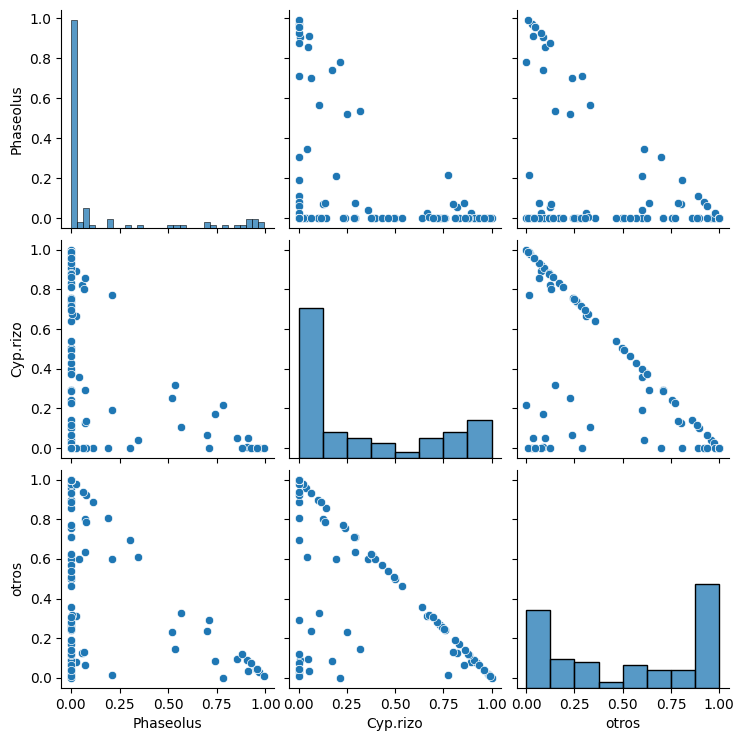

In [579]:
sns.pairplot(df3[['Phaseolus', 'Cyp.rizo', 'otros']])

Estos 3 alimentos muestran una relacion notoria y por eso se tomaron (mejora la redaccion)

In [163]:
#se filtra por 3 alimentos, jovenes mans
food_ = ['Phaseolus', 'Cyp.rizo', 'otros'] 
foodnt_ = set(alimentos_conservar) - set(food_)
foodnt_ = list(foodnt_)
df3 = df[cob_columns + food_][(df.edad == 'J') & (df.sexo == 'Male')].copy()
df3['otros'] = df[foodnt_ + ['otros']].sum(axis = 1) #ajuste variable otros
df3[food_] = df3[food_].div(df['peso total'], axis = 0)
df3

,edad,sexo,estado,time,covey,dist camino,ppanual17,tmedia17,altitud,lat,lon,hcrop,hland,gap,Phaseolus,Cyp.rizo,otros
1,J,Male,NM,1420.0,6.0,251.86,462.0,7.054167,2518.0,34.037969,-108.963777,0.000000,0.798600,Rocky Mountain Ponderosa Pine Woodland,0.000000,0.000000,1.000000
4,J,Male,AZ,1600.0,8.0,236.76,521.0,16.133333,1507.0,31.353053,-110.531060,1.680150,1.541562,Apacherian-Chihuahuan Mesquite Upland Scrub,0.071536,0.127915,0.800549
6,J,Male,NM,1245.0,15.0,190.95,406.0,9.987500,1993.0,33.289458,-108.061378,0.733283,0.637185,Rocky Mountain Ponderosa Pine Woodland,0.000000,0.000000,1.000000
8,J,Male,AZ,1130.0,8.0,26.67,504.0,15.675000,1546.0,31.444386,-110.543406,0.820472,1.604740,North American Warm Desert Wash,0.000000,0.000000,1.000000
10,J,Male,AZ,1600.0,8.0,236.76,521.0,16.133333,1507.0,31.353053,-110.531060,1.574838,1.541562,Apacherian-Chihuahuan Mesquite Upland Scrub,0.073224,0.290236,0.636540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,J,Male,NM,1120.0,12.0,239.32,423.0,14.225000,1658.0,31.520878,-108.983869,0.692055,1.137096,Madrean Juniper Savanna,0.000000,0.694377,0.305623
307,J,Male,NM,1115.0,4.0,376.44,423.0,14.225000,1684.0,31.521565,-108.985086,1.327827,1.146510,Madrean Juniper Savanna,0.074498,0.859402,0.066099
309,J,Male,NM,1115.0,4.0,376.44,423.0,14.225000,1684.0,31.521565,-108.985086,0.697384,1.146510,Madrean Juniper Savanna,0.347399,0.041490,0.611111
311,J,Male,NM,1430.0,10.0,715.30,336.0,14.383333,1639.0,32.517895,-107.169283,0.000000,1.083555,Madrean Pinyon-Juniper Woodland,0.954586,0.000000,0.045414


In [180]:
# df3.to_csv('./JM3.csv')
# df3[df3.time >1300].to_csv('./JM3T12.csv') me lo lleve a R

## Resultados regresion

Se tomaron las variables Phaseolus, Cyp.rizo y otros (como se dijo arriba), se restringió la poblacion en jovenes machos.



En este caso, se obtuvieron resultados significativos para todas las variables. Ahora podemos modelar el vector aleatorio $\mathbf{Y}$ de la siguiente manera:

$$ \mathbf{Y|X} = x\hspace{0.2cm} \sim Dir(\mathbf{\alpha}(x)) $$

Por consiguiente tenemos que las densidades marginales estan dadas de la siguiente manera

$$Y_i| \mathbb{X}  = x\hspace{0.2cm} \sim Beta(\alpha_i(x), \alpha_i(x) - \alpha_0 (x))$$

y por consiguiente podemos conocer su media

$$ \mathbb{E}[Y_i \mid \mathbf{X} = x] = \frac{\alpha_i(x)}{\alpha_0(x)} $$




In [580]:
Alpha_1 = lambda dist_camino: np.exp(-1.918277 + 0.002332 * dist_camino)
Alpha_2 = lambda hcrop: np.exp(-1.3261 * hcrop)
Alpha_3 = lambda covey: np.exp(-0.02902 * covey)

#estas funciones alphas se obtienen de la regresion hecha en R

In [339]:
np.median(df3.covey.dropna()), np.median(df3.hcrop.dropna()) #estos se dejan fija al desconocerse

(10.0, 0.6003174385000001)

In [585]:
plt.style.use('seaborn-v0_8')

Text(0.5, 1.0, '')

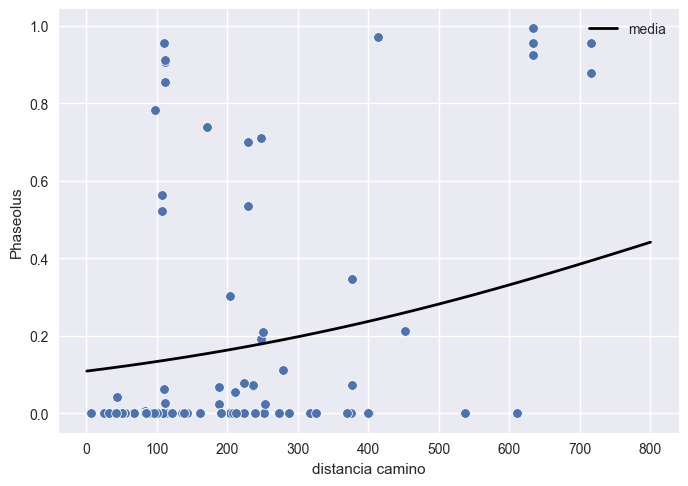

In [586]:
#se calcula el grid sobre el cual se va a aplicar
dist_camino_values = np.linspace(1, 800, 30) #se varia dist camino
hcrop_values = np.array(30 * [np.median(df3.hcrop.dropna())]) #se toma media hcrop
covey_values = np.array(30 * [np.median(df3.covey.dropna())]) #se toma media covey

alpha_1 = Alpha_1(dist_camino_values) #paramtro de beta
alpha_2 = Alpha_2(hcrop_values) 
alpha_3 = Alpha_3(covey_values)
alpha_0 = alpha_1 + alpha_2 + alpha_3

beta_1 =alpha_0 - alpha_1 #parametro de beta

mean_phaseolus = alpha_1 / (alpha_1 + beta_1) #vector de medias con x = dist camino



#Phaseolus scatter y media
ax = plt.gca()

sns.scatterplot(y = Phaseolus_,
                x = df3['dist camino'].values)

sns.lineplot(y = alpha_1 / alpha_0,
                x = dist_camino_values,
            color = 'black',
            label = 'media',
             linewidth = 2)
ax.set_ylabel('Phaseolus')
ax.set_xlabel('distancia camino')

# prop_to_use = 20
# dist_to_use = 40

# grid_d = np.empty((prop_to_use, dist_to_use))


# def get_density(dist_, prop_):
#     alpha_1 = Alpha_1(dist_)
#     alpha_2 = Alpha_2(0.6)
#     alpha_3 = Alpha_3(10)
#     alpha_0 = alpha_1 + alpha_2 + alpha_3
#     beta_1 = alpha_0 - alpha_1    
#     return beta.pdf(prop_, 
#                      alpha_1, 
#                      beta_1)

# for row in range(grid_s.shape[0]):
#     for value in  range(grid_s.shape[1]):
#         dist_ = (value / dist_to_use) * 800
#         prop_ = (row / prop_to_use)
#         grid_s[row, value] = get_density(dist_, prop_)


# max_d = np.max(grid_s[np.isfinite(grid_s)])
# grid_d = np.where(grid_s > max_d, max_d, grid_s)


# im  = ax.imshow(grid_d, 
#           extent=[0, 800, 0, 1], 
#           origin='lower',
#           cmap='viridis', 
#           aspect='auto',
#           alpha=1
#          )
# cbar = plt.colorbar(im, ax=ax)
# cbar.set_label('Densidad')


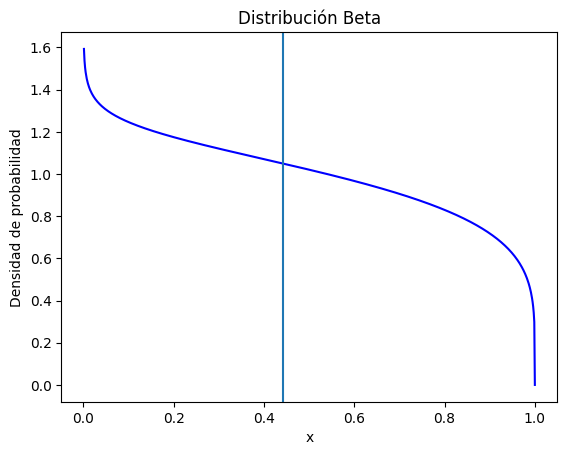

In [560]:
#este bloque se puede ignorar, era para ver la dsitribucion beta
# Parámetros alpha y beta de la distribución Beta
dist_camino_ = 800


alpha_1 = Alpha_1(dist_camino_)
alpha_2 = Alpha_2(0.6)
alpha_3 = Alpha_3(10)
alpha_0 = alpha_1 + alpha_2 + alpha_3
beta_1 = alpha_0 - alpha_1

# Secuencia de valores para la variable
x = np.linspace(0, 1, 800)

# Calcular la densidad de probabilidad de la distribución Beta
densidad_beta = beta.pdf(x, 
                         alpha_1, 
                         beta_1)
# ax = plt.gca()
# Graficar la distribución Beta

ax = plt.gca()

sns.lineplot(x= x, y = densidad_beta, color='blue', ax = ax)
ax.set_title('Distribución Beta')
ax.set_xlabel('x')
ax.set_ylabel('Densidad de probabilidad')
# plt.grid(True)
# plt.show()

plt.axvline(alpha_1 / alpha_0)

Text(0.5, 0, 'hcrop')

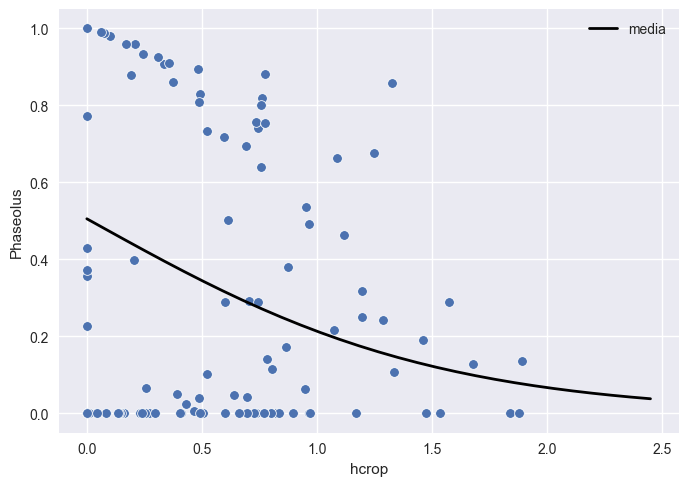

In [587]:
#se calcula el grid sobre el cual se va a aplicar
dist_camino_values = np.array(30 * [np.median(df3[ 'dist camino'].dropna())]) #se varia dist camino
hcrop_values = np.linspace(0, 2.45, 30) #se toma media hcrop
covey_values = np.array(30 * [np.median(df3.covey.dropna())]) #se toma media covey

alpha_1 = Alpha_1(dist_camino_values) #paramtro de beta
alpha_2 = Alpha_2(hcrop_values) 
alpha_3 = Alpha_3(covey_values)
alpha_0 = alpha_1 + alpha_2 + alpha_3

beta_2 = alpha_0 - alpha_2 #parametro de beta

mean_cyp = alpha_2 / (alpha_2 + beta_2) #vector de medias con x = dist camino



#Phaseolus
ax = plt.gca()

sns.scatterplot(y = cyp_rizo,
                x = df3['hcrop'].values)

sns.lineplot(y = alpha_2 / alpha_0,#alpha_1 / (alpha_1 + beta_1 ),
                x = hcrop_values,
            color = 'black',
            label = 'media',
             linewidth = 2)
ax.set_ylabel('Phaseolus')
ax.set_xlabel('hcrop')


#se agrega el mapa de calor
# prop_to_use = 20
# dist_to_use = 40

# grid_d = np.empty((prop_to_use, dist_to_use))


# def get_density(hcrop_, prop_):
#     alpha_1 = Alpha_1(190.95)
#     alpha_2 = Alpha_2(hcrop_)
#     alpha_3 = Alpha_3(10)
#     alpha_0 = alpha_1 + alpha_2 + alpha_3
#     beta_2 = alpha_0 - alpha_2    
#     return beta.pdf(prop_, 
#                      alpha_2, 
#                      beta_2)

# for row in range(grid_s.shape[0]):
#     for value in  range(grid_s.shape[1]):
#         hcrop_ = (value / dist_to_use) * 2.45
#         prop_ = (row / prop_to_use)
#         grid_s[row, value] = get_density(hcrop_, prop_)


# max_d = np.max(grid_s[np.isfinite(grid_s)])
# grid_d = np.where(grid_s > max_d, max_d, grid_s)


# im  = ax.imshow(grid_d, 
#           extent=[0, 2.45, 0, 1], 
#           origin='lower',
#           cmap='viridis', 
#           aspect='auto',
#           alpha=1
#          )
# cbar = plt.colorbar(im, ax=ax)
# cbar.set_label('Densidad')

Text(0.5, 0, 'covey')

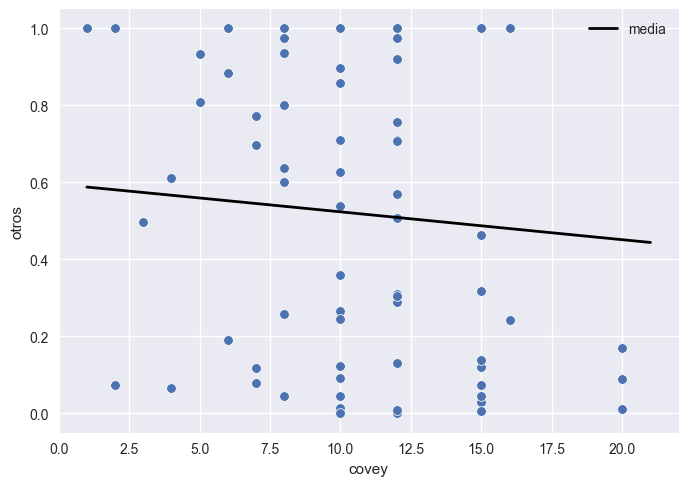

In [588]:
#se calcula el grid sobre el cual se va a aplicar
dist_camino_values = np.array(30 * [np.median(df3[ 'dist camino'].dropna())]) #se varia dist camino
hcrop_values = np.array(30 * [np.median(df3.hcrop.dropna())]) #se toma media hcrop
covey_values = np.linspace(1, 21, 30) #se toma media covey

alpha_1 = Alpha_1(dist_camino_values) #paramtro de beta
alpha_2 = Alpha_2(hcrop_values) 
alpha_3 = Alpha_3(covey_values)
alpha_0 = alpha_1 + alpha_2 + alpha_3

beta_3 =alpha_0 - alpha_3 #parametro de beta

mean_otros = alpha_3 / (alpha_3 + beta_3) #vector de medias con x = dist camino



#Phaseolus
ax = plt.gca()

sns.scatterplot(y = otros_,
                x = df3['covey'].values)

sns.lineplot(y = alpha_3 / alpha_0,#alpha_1 / (alpha_1 + beta_1 ),
                x = covey_values,
            color = 'black',
            label = 'media',
             linewidth = 2)
ax.set_ylabel('otros')
ax.set_xlabel('covey')




#se agrega el mapa de calor
# prop_to_use = 50
# dist_to_use = 90

# grid_d = np.empty((prop_to_use, dist_to_use))


# def get_density(covey_, prop_):
#     alpha_1 = Alpha_1(190.95)
#     alpha_2 = Alpha_2(0.6)
#     alpha_3 = Alpha_3(covey_)
#     alpha_0 = alpha_1 + alpha_2 + alpha_3
#     beta_3 = alpha_0 - alpha_3    
#     return beta.pdf(prop_, 
#                      alpha_3, 
#                      beta_3)

# for row in range(grid_s.shape[0]):
#     for value in  range(grid_s.shape[1]):
#         hcrop_ = (value / dist_to_use) * 21
#         prop_ = (row / prop_to_use)
#         grid_s[row, value] = get_density(hcrop_, prop_)


# max_d = np.max(grid_s[np.isfinite(grid_s)])
# grid_d = np.where(grid_s > max_d, max_d, grid_s)


# im  = ax.imshow(grid_d, 
#           extent=[0, 21, 0, 1], 
#           origin='lower',
#           cmap='viridis', 
#           aspect='auto',
#           alpha=1
#          )
# cbar = plt.colorbar(im, ax=ax)
# cbar.set_label('Densidad')

[None]

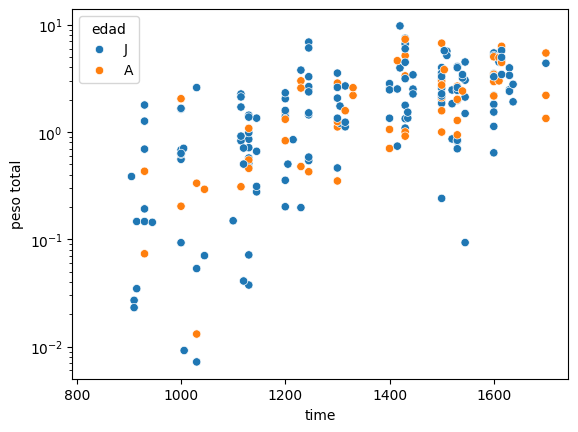

In [115]:
ax = plt.gca()
sns.scatterplot(x = 'time',
                y = 'peso total',
                hue = 'edad',
               data = df2)

ax.set(yscale="log")

[None]

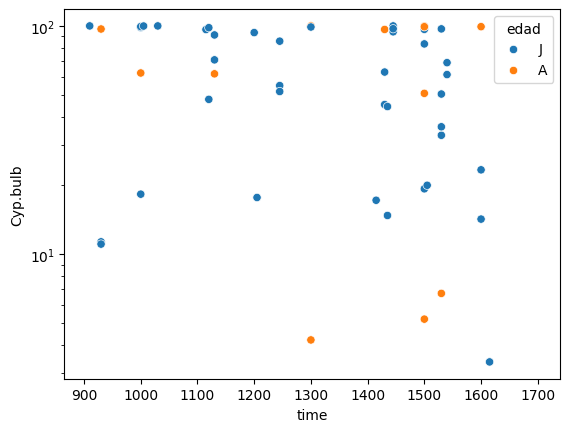

In [83]:
ax = plt.gca()
sns.scatterplot(x = 'time',
                y = 'Cyp.bulb',
                hue = 'edad',
               data = df2)

ax.set(yscale="log")

In [73]:
cob_columns

['edad',
 'sexo',
 'estado',
 'time',
 'covey',
 'dist camino',
 'ppanual17',
 'tmedia17',
 'altitud',
 'lat',
 'lon',
 'hcrop',
 'hland',
 'gap']

In [84]:
df2.gap.value_counts()

gap
Apacherian-Chihuahuan Piedmont Semi-Desert Grassland and Steppe    52
Madrean Pinyon-Juniper Woodland                                    51
Madrean Encinal                                                    26
Colorado Plateau Pinyon-Juniper Woodland                           26
Apacherian-Chihuahuan Mesquite Upland Scrub                        18
Rocky Mountain Ponderosa Pine Woodland                             12
Madrean Juniper Savanna                                             8
Chihuahuan Creosotebush, Mixed Desert and Thorn Scrub               7
Mogollon Chaparral                                                  7
Southern Rocky Mountain Pinyon-Juniper Woodland                     5
North American Warm Desert Wash                                     3
Chihuahuan Mixed Salt Desert Scrub                                  3
Rocky Mountain Gambel Oak-Mixed Montane Shrubland                   2
North American Warm Desert Bedrock Cliff and Outcrop                1
Name: count, dty

<Axes: xlabel='hland', ylabel='Cyp.rizo'>

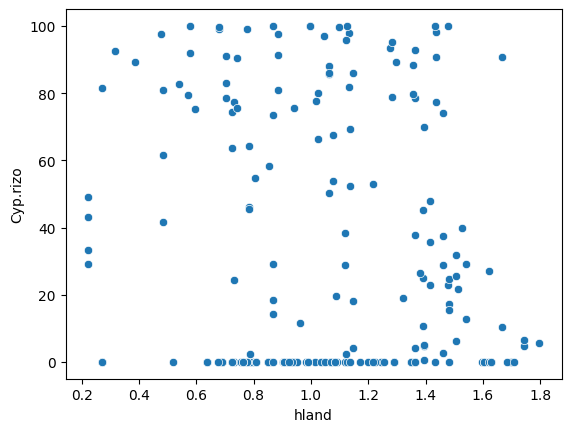

In [76]:
#no tiene ningun efecto en la distribucion del peso total
sns.scatterplot(x = 'hland',
               y = 'Cyp.rizo',
               data = df2)

<Axes: xlabel='altitud', ylabel='peso total'>

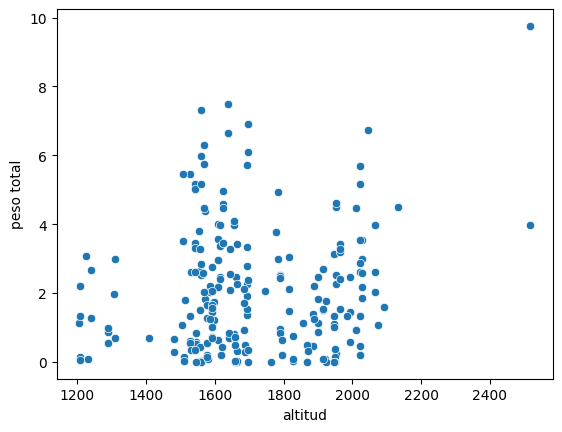

In [77]:
#si cambia la distrib
sns.scatterplot(x = 'altitud',
               y = 'peso total',
               data = df2) 

<Axes: xlabel='tmedia17', ylabel='peso total'>

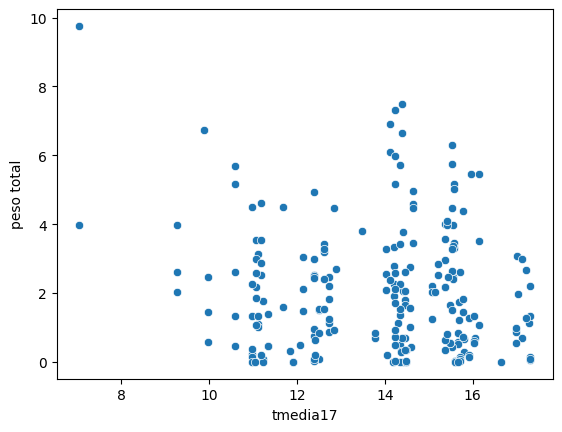

In [85]:
#sin efecto
sns.scatterplot(x = 'tmedia17',
               y = 'peso total',
               data = df2) 

<Axes: xlabel='ppanual17', ylabel='peso total'>

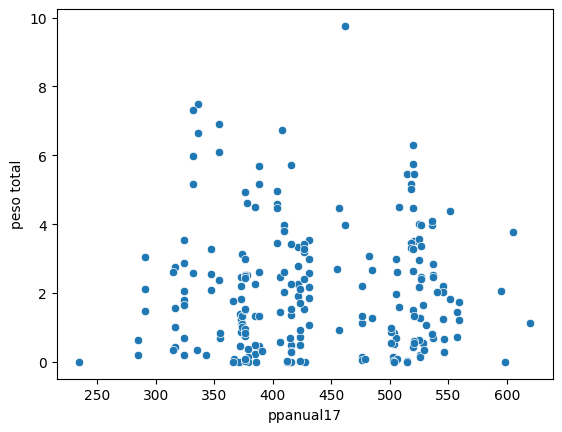

In [86]:
sns.scatterplot(x = 'ppanual17',
               y = 'peso total',
               data = df2) 

In [102]:
cob_columns

['edad',
 'sexo',
 'estado',
 'time',
 'covey',
 'dist camino',
 'ppanual17',
 'tmedia17',
 'altitud',
 'lat',
 'lon',
 'hcrop',
 'hland',
 'gap']

In [119]:
cob_columns + most_var_food[0:3]

['edad',
 'sexo',
 'estado',
 'time',
 'covey',
 'dist camino',
 'ppanual17',
 'tmedia17',
 'altitud',
 'lat',
 'lon',
 'hcrop',
 'hland',
 'gap',
 'Cyp.rizo',
 'Quercus',
 'Cyp.bulb']

In [118]:
corr_ = df2[cob_columns + most_var_food[0:3]].corr()
plt.figure(figsize=(18, 10))
sns.heatmap(corr_, annot=True, cmap="coolwarm")
plt.title("")
plt.show()

ValueError: could not convert string to float: 'J'

<Axes: xlabel='ppanual17', ylabel='Quercus'>

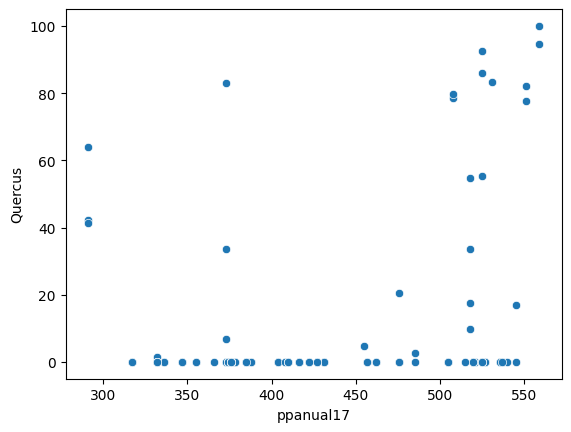

In [99]:
sns.scatterplot(x = 'ppanual17',
                y = 'Quercus',
               data = df2[df2.time > 1300])

<Axes: xlabel='altitud', ylabel='Urochloa'>

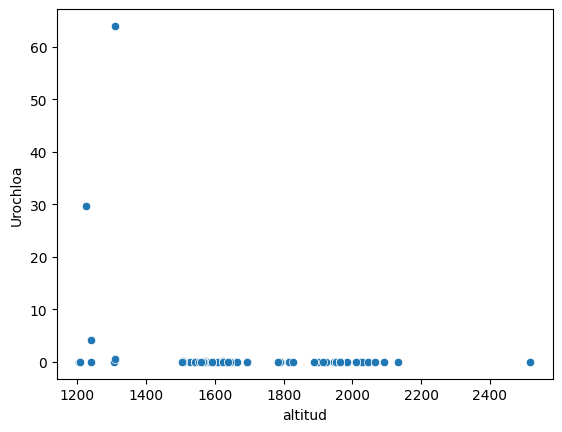

In [117]:
sns.scatterplot(x = 'altitud',
                y = 'Urochloa',
               data = df2[df2.time > 1300])